In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import folium
from folium.plugins import HeatMap, MarkerCluster
import io
import csv
import warnings
from IPython.display import display
warnings.filterwarnings('ignore')

In [7]:

# Set styling for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
colors = sns.color_palette('viridis', 6)

print("="*50)
print("EARTHQUAKE DIAGNOSTIC ANALYTICS")
print("="*50)

EARTHQUAKE DIAGNOSTIC ANALYTICS


In [8]:
from datetime import datetime

def load_earthquake_data(file_path='all_month.csv'):
    try:
        # Read the CSV directly
        df = pd.read_csv(file_path)
        
        # Convert numeric columns
        numeric_cols = [
            'latitude', 'longitude', 'depth', 'mag', 'nst', 'gap', 'dmin', 'rms',
            'horizontalError', 'depthError', 'magError', 'magNst'
        ]
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Convert time column to datetime
        if 'time' in df.columns:
            df['time'] = pd.to_datetime(df['time'], errors='coerce')
        
        return df
    
    except Exception as e:
        print("Error loading data:", str(e))
        return None
print("Loading and processing earthquake data...")
df = load_earthquake_data()

Loading and processing earthquake data...


In [9]:
print(f"\nDataset has {df.shape[0]} earthquakes with {df.shape[1]} attributes")
print(f"Magnitude range: {df['mag'].min():.1f} to {df['mag'].max():.1f}")
print(f"Depth range: {df['depth'].min():.1f} to {df['depth'].max():.1f} km")


Dataset has 10177 earthquakes with 22 attributes
Magnitude range: -1.3 to 6.9
Depth range: -3.4 to 642.9 km


# 1. CORRELATION ANALYSIS BETWEEN DEPTH, MAGNITUDE, AND LOCATION 

In [10]:
print("\n" + "="*20)
print("CORRELATION ANALYSIS")
print("="*20)

# Calculate correlations between key features
corr_features = ['latitude', 'longitude', 'depth', 'mag', 'rms', 'gap', 'nst']
corr_matrix = df[corr_features].corr()
print("\nCorrelation Matrix for Key Features:")
print(corr_matrix[['depth', 'mag']].sort_values(by='mag', ascending=False))

# Create a heatmap of correlations
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Earthquake Features', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.close()

# Magnitude vs Depth with regression line
plt.figure(figsize=(10, 8))
sns.regplot(x='depth', y='mag', data=df, scatter_kws={'alpha':0.4, 's':50}, line_kws={'color':'red'})
plt.title('Relationship Between Earthquake Magnitude and Depth', fontsize=16)
plt.xlabel('Depth (km)', fontsize=14)
plt.ylabel('Magnitude', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Calculate and show regression statistics
slope, intercept, r_value, p_value, std_err = stats.linregress(df['depth'].dropna(), df['mag'].dropna())
plt.annotate(f'R² = {r_value**2:.3f}\np-value = {p_value:.3e}', 
             xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.savefig('magnitude_depth_regression.png')
plt.close()


CORRELATION ANALYSIS

Correlation Matrix for Key Features:
              depth       mag
mag        0.382165  1.000000
rms        0.355725  0.679836
longitude  0.136261  0.580742
nst        0.216789  0.561048
depth      1.000000  0.382165
gap        0.006608 -0.060462
latitude  -0.234787 -0.566605


# 2. PROXIMITY ANALYSIS TO TECTONIC ZONES


In [11]:
print("\n" + "="*20)
print("TECTONIC PROXIMITY ANALYSIS")
print("="*20)

# Define approximate locations of major tectonic boundaries
# This is a simplified approach - in a real analysis you'd use GIS data for tectonic plates
tectonic_features = {
    'San Andreas Fault': {'lat': 37.75, 'lon': -122.45},
    'Aleutian Trench': {'lat': 51.5, 'lon': -175.0},
    'Puerto Rico Trench': {'lat': 19.8, 'lon': -67.0},
    'Ring of Fire - Indonesia': {'lat': -5.5, 'lon': 125.0},
    'Pacific-Antarctic Ridge': {'lat': -54.0, 'lon': -125.0},
    'East Pacific Rise': {'lat': 10.0, 'lon': -104.5},
}

# Function to calculate distance between two points on Earth (Haversine formula)
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Calculate distance to each tectonic feature
for feature, coords in tectonic_features.items():
    df[f'distance_to_{feature.replace(" ", "_")}'] = df.apply(
        lambda row: haversine_distance(row['latitude'], row['longitude'], 
                                      coords['lat'], coords['lon']), axis=1)

# Find the nearest tectonic feature for each earthquake
tectonic_distance_cols = [col for col in df.columns if col.startswith('distance_to_')]
df['nearest_feature'] = df[tectonic_distance_cols].idxmin(axis=1)
df['nearest_feature'] = df['nearest_feature'].str.replace('distance_to_', '').str.replace('_', ' ')
df['distance_to_nearest'] = df[tectonic_distance_cols].min(axis=1)

# Analyze magnitude by nearest tectonic feature
tectonic_analysis = df.groupby('nearest_feature').agg({
    'mag': ['count', 'mean', 'max'],
    'depth': ['mean', 'max'],
    'distance_to_nearest': 'mean'
})

print("\nEarthquake Distribution by Nearest Tectonic Feature:")
print(tectonic_analysis)

# Visualize magnitude vs nearest tectonic feature
plt.figure(figsize=(12, 6))
sns.boxplot(x='nearest_feature', y='mag', data=df, palette='viridis')
plt.title('Earthquake Magnitude Distribution by Nearest Tectonic Feature', fontsize=16)
plt.xlabel('Nearest Tectonic Feature', fontsize=14)
plt.ylabel('Magnitude', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('magnitude_by_tectonic_feature.png')
plt.close()

# Calculate correlation between distance to nearest feature and magnitude
distance_mag_corr = df['distance_to_nearest'].corr(df['mag'])
print(f"\nCorrelation between distance to nearest tectonic feature and magnitude: {distance_mag_corr:.3f}")



TECTONIC PROXIMITY ANALYSIS

Earthquake Distribution by Nearest Tectonic Feature:
                           mag                       depth           \
                         count      mean   max        mean      max   
nearest_feature                                                       
Aleutian Trench           2729  1.355966  5.90   32.342645  382.253   
East Pacific Rise           49  3.238776  5.20   18.391802  172.523   
Pacific-Antarctic Ridge    163  4.660123  6.80  217.507135  642.872   
Puerto Rico Trench         425  3.207506  6.90   38.354155  538.156   
Ring of Fire - Indonesia   529  4.586011  6.90   49.403985  629.875   
San Andreas Fault         6282  1.097230  5.21    6.516560   45.320   

                         distance_to_nearest  
                                        mean  
nearest_feature                               
Aleutian Trench                  1419.764804  
East Pacific Rise                1895.036761  
Pacific-Antarctic Ridge          5230.7010

# 3. IDENTIFICATION OF CONTRIBUTING FACTORS TO SEVERE QUAKES


ANALYSIS OF SEVERE EARTHQUAKE FACTORS

Percentage of severe earthquakes (mag >= 4.0): 9.05%

Comparison of Severe vs. Non-Severe Earthquakes:
               depth                           nst                    \
                mean median         std       mean median        std   
is_severe                                                              
False      14.218660   6.61   24.171559  19.886455   15.0  15.960106   
True       82.934065  10.00  138.651332  52.222588   40.0  41.350153   

                  gap                        dmin                      \
                 mean median        std      mean    median       std   
is_severe                                                               
False      112.605290   93.0  66.214744  0.094143  0.043192  0.238710   
True       105.572171  102.0  46.638552  3.341933  2.156000  4.173429   

                rms                   
               mean median       std  
is_severe                             
False      0.

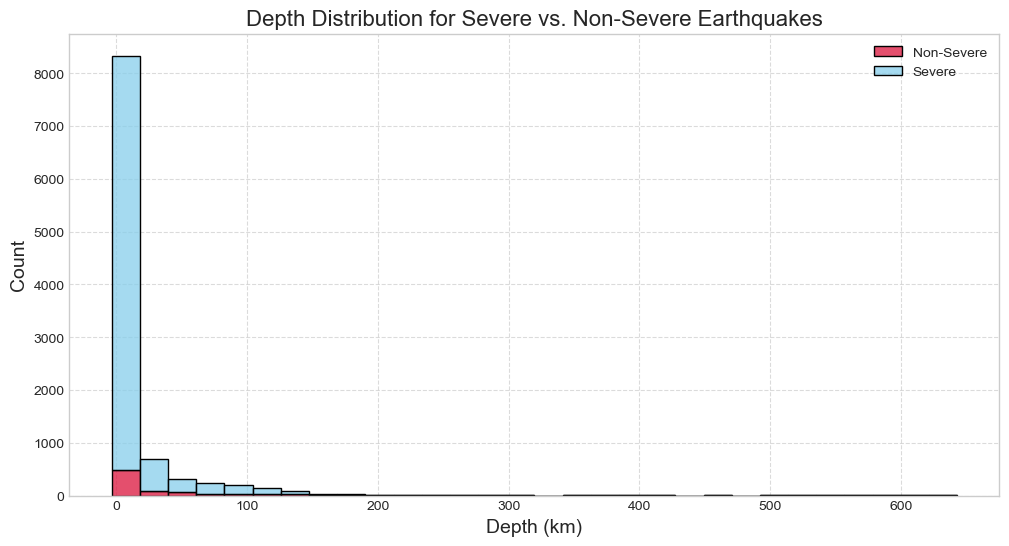

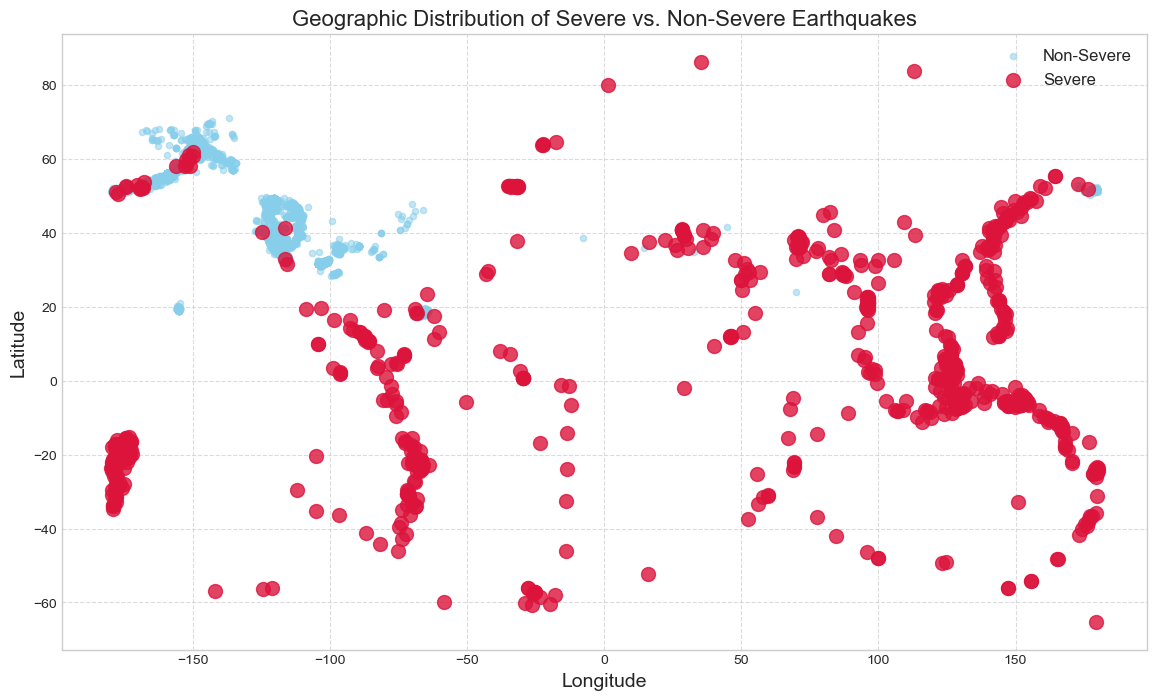

ValueError: array must not contain infs or NaNs

In [16]:
print("\n" + "="*20)
print("ANALYSIS OF SEVERE EARTHQUAKE FACTORS")
print("="*20)

# Define severity threshold (e.g., magnitude >= 4.0)
severity_threshold = 4.0
df['is_severe'] = df['mag'] >= severity_threshold
severe_percentage = df['is_severe'].mean() * 100

print(f"\nPercentage of severe earthquakes (mag >= {severity_threshold}): {severe_percentage:.2f}%")

# Compare characteristics of severe vs. non-severe earthquakes
comparison_features = ['depth', 'nst', 'gap', 'dmin', 'rms']
severe_stats = df.groupby('is_severe')[comparison_features].agg(['mean', 'median', 'std'])
print("\nComparison of Severe vs. Non-Severe Earthquakes:")
print(severe_stats)

# -------------------------------
# Depth Histogram
# -------------------------------
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='depth', hue='is_severe', bins=30, multiple='stack', palette=['skyblue', 'crimson'])
plt.title('Depth Distribution for Severe vs. Non-Severe Earthquakes', fontsize=16)
plt.xlabel('Depth (km)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(['Non-Severe', 'Severe'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('severity_by_depth.png')
plt.show()
plt.close()

# -------------------------------
# Scatter Plot (Static) Map
# -------------------------------
plt.figure(figsize=(14, 8))
plt.scatter(df[~df['is_severe']]['longitude'], df[~df['is_severe']]['latitude'], 
            c='skyblue', alpha=0.5, s=20, label='Non-Severe')
plt.scatter(df[df['is_severe']]['longitude'], df[df['is_severe']]['latitude'], 
            c='crimson', alpha=0.8, s=100, label='Severe')
plt.title('Geographic Distribution of Severe vs. Non-Severe Earthquakes', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('severity_geographic_distribution.png')
plt.show()
plt.close()

# -------------------------------
# Statistical Correlation
# -------------------------------
factor_correlations = {}
for feature in comparison_features:
    if feature in df.columns:
        corr, p_value = pointbiserialr(df['is_severe'], df[feature])
        factor_correlations[feature] = {'correlation': corr, 'p_value': p_value}

print("\nPoint-Biserial Correlation between Features and Earthquake Severity:")
for feature, stats in sorted(factor_correlations.items(), key=lambda x: abs(x[1]['correlation']), reverse=True):
    significance = "significant" if stats['p_value'] < 0.05 else "not significant"
    print(f"{feature}: correlation = {stats['correlation']:.3f}, p-value = {stats['p_value']:.3e} ({significance})")

# -------------------------------
# Interactive Map with Folium
# -------------------------------
map_center = [df['latitude'].mean(), df['longitude'].mean()]
folium_map = folium.Map(location=map_center, zoom_start=5, tiles='Stamen Terrain')

# Add marker clusters for better performance
marker_cluster = MarkerCluster().add_to(folium_map)

# Add severe and non-severe markers
for idx, row in df.iterrows():
    location = [row['latitude'], row['longitude']]
    if row['is_severe']:
        folium.CircleMarker(
            location=location,
            radius=6,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            popup=f"Severe Quake\nMag: {row['mag']}, Depth: {row['depth']} km"
        ).add_to(marker_cluster)
    else:
        folium.CircleMarker(
            location=location,
            radius=3,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.4,
            popup=f"Non-Severe Quake\nMag: {row['mag']}, Depth: {row['depth']} km"
        ).add_to(marker_cluster)

# Show inline in notebook OR save as HTML
try:
    display(folium_map)  # Jupyter-friendly
except:
    folium_map.save("earthquake_severity_map.html")
    import webbrowser
    webbrowser.open("earthquake_severity_map.html")

# 4. CLUSTER ANALYSIS OF HIGH-IMPACT ZONES

In [ ]:
print("\n" + "="*20)
print("CLUSTER ANALYSIS OF EARTHQUAKE ZONES")
print("="*20)

# Prepare data for clustering (using geographic coordinates and magnitude)
cluster_features = ['latitude', 'longitude', 'mag', 'depth']
cluster_data = df[cluster_features].dropna()

# Standardize the data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Perform KMeans clustering
n_clusters = 5  # You can adjust this based on domain knowledge
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_with_kmeans = cluster_data.copy()
df_with_kmeans['cluster'] = kmeans.fit_predict(scaled_data)

# Analyze the clusters
cluster_analysis = df_with_kmeans.groupby('cluster').agg({
    'latitude': ['mean', 'min', 'max'],
    'longitude': ['mean', 'min', 'max'],
    'mag': ['count', 'mean', 'max'],
    'depth': ['mean', 'min', 'max']
})

print("\nK-Means Cluster Analysis Results:")
print(cluster_analysis)

# Visualize the clusters geographically
plt.figure(figsize=(14, 8))
scatter = plt.scatter(df_with_kmeans['longitude'], df_with_kmeans['latitude'], 
                     c=df_with_kmeans['cluster'], cmap='viridis', 
                     alpha=0.7, s=df_with_kmeans['mag']**2)
plt.colorbar(scatter, label='Cluster')
plt.title('Geographic Clusters of Earthquakes', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('earthquake_clusters.png')
plt.close()

# Try DBSCAN for density-based clustering (better for irregular shapes)
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust parameters based on your data
df_with_dbscan = cluster_data.copy()
df_with_dbscan['cluster'] = dbscan.fit_predict(scaled_data)
n_dbscan_clusters = len(set(df_with_dbscan['cluster'])) - (1 if -1 in df_with_dbscan['cluster'] else 0)

print(f"\nDBSCAN identified {n_dbscan_clusters} clusters and {(df_with_dbscan['cluster'] == -1).sum()} noise points")

# Analyze DBSCAN clusters (excluding noise points)
if n_dbscan_clusters > 0:
    dbscan_analysis = df_with_dbscan[df_with_dbscan['cluster'] != -1].groupby('cluster').agg({
        'latitude': ['mean', 'count'],
        'longitude': 'mean',
        'mag': ['mean', 'max'],
        'depth': 'mean'
    })
    print("\nDBSCAN Cluster Analysis (excluding noise):")
    print(dbscan_analysis)


# 5. INSIGHTS INTO RECURRING PATTERNS OR ANOMALIES

In [13]:
print("\n" + "="*20)
print("SWARM ANALYSIS & PATTERN IDENTIFICATION")
print("="*20)

# Identify potential earthquake swarms (many earthquakes in close proximity)
# First, group by locations that are very close to each other
# For simplicity, we'll round coordinates to 1 decimal place (approx 11km precision)
df['lat_round'] = df['latitude'].round(1)
df['lon_round'] = df['longitude'].round(1)
df['location_group'] = df['lat_round'].astype(str) + "_" + df['lon_round'].astype(str)

# Count earthquakes per location group
location_counts = df.groupby('location_group').size().sort_values(ascending=False)
potential_swarms = location_counts[location_counts >= 5]  # At least 5 earthquakes in same area

print(f"\nIdentified {len(potential_swarms)} potential earthquake swarms (5+ quakes in same area)")
print("\nTop 10 active areas:")
for i, (location, count) in enumerate(potential_swarms.head(10).items()):
    lat, lon = location.split('_')
    avg_mag = df[df['location_group'] == location]['mag'].mean()
    print(f"{i+1}. Area around {lat}°, {lon}°: {count} earthquakes, avg magnitude: {avg_mag:.2f}")

# Analyze the largest swarm in more detail
if len(potential_swarms) > 0:
    largest_swarm_location = potential_swarms.index[0]
    largest_swarm = df[df['location_group'] == largest_swarm_location].copy()
    largest_swarm = largest_swarm.sort_values('time')
    
    print(f"\nAnalyzing largest swarm at {largest_swarm_location}:")
    print(f"- Number of earthquakes: {len(largest_swarm)}")
    print(f"- Magnitude range: {largest_swarm['mag'].min():.2f} to {largest_swarm['mag'].max():.2f}")
    print(f"- Depth range: {largest_swarm['depth'].min():.2f} to {largest_swarm['depth'].max():.2f} km")
    
    # Check for temporal patterns in the swarm
    largest_swarm['hour'] = largest_swarm['time'].dt.hour
    hourly_distribution = largest_swarm['hour'].value_counts().sort_index()
    
    plt.figure(figsize=(12, 6))
    hourly_distribution.plot(kind='bar', color='teal')
    plt.title(f'Hourly Distribution of Earthquakes in Largest Swarm ({largest_swarm_location})', fontsize=16)
    plt.xlabel('Hour of Day (UTC)', fontsize=14)
    plt.ylabel('Number of Earthquakes', fontsize=14)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('swarm_hourly_distribution.png')
    plt.close()
    
    # Check for magnitude progression in the swarm
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(largest_swarm)), largest_swarm['mag'], alpha=0.7)
    plt.plot(range(len(largest_swarm)), largest_swarm['mag'].rolling(window=3).mean(), 'r-')
    plt.title(f'Magnitude Progression in Largest Swarm ({largest_swarm_location})', fontsize=16)
    plt.xlabel('Earthquake Sequence', fontsize=14)
    plt.ylabel('Magnitude', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('swarm_magnitude_progression.png')
    plt.close()

# Analyze anomalies (unusually large earthquakes)
magnitude_threshold = df['mag'].quantile(0.95)  # Top 5% by magnitude
anomalies = df[df['mag'] >= magnitude_threshold]

print(f"\nIdentified {len(anomalies)} anomalous earthquakes (magnitude >= {magnitude_threshold:.2f})")
print("\nTop 5 anomalous earthquakes:")
for idx, row in anomalies.sort_values('mag', ascending=False).head(5).iterrows():
    print(f"- Magnitude {row['mag']:.1f} at {row['place']} (depth: {row['depth']:.1f} km)")

# Check if anomalies are clustered or dispersed
anomaly_distances = []
for i, row1 in anomalies.iterrows():
    for j, row2 in anomalies.iterrows():
        if i < j:  # Avoid duplicate pairs
            dist = haversine_distance(row1['latitude'], row1['longitude'], 
                                     row2['latitude'], row2['longitude'])
            anomaly_distances.append(dist)

if anomaly_distances:
    avg_anomaly_distance = np.mean(anomaly_distances)
    print(f"\nAverage distance between anomalous earthquakes: {avg_anomaly_distance:.1f} km")
    
    # Random sampling for comparison
    random_sample = df.sample(len(anomalies))
    random_distances = []
    for i, row1 in random_sample.iterrows():
        for j, row2 in random_sample.iterrows():
            if i < j:  # Avoid duplicate pairs
                dist = haversine_distance(row1['latitude'], row1['longitude'], 
                                         row2['latitude'], row2['longitude'])
                random_distances.append(dist)
    
    avg_random_distance = np.mean(random_distances)
    print(f"Average distance between random earthquakes: {avg_random_distance:.1f} km")
    
    if avg_anomaly_distance < avg_random_distance:
        print("Anomalous earthquakes appear to be more clustered than random earthquakes")
    else:
        print("Anomalous earthquakes do not appear to be clustered")



SWARM ANALYSIS & PATTERN IDENTIFICATION

Identified 269 potential earthquake swarms (5+ quakes in same area)

Top 10 active areas:
1. Area around 38.8°, -122.8°: 1412 earthquakes, avg magnitude: 0.76
2. Area around 33.0°, -116.6°: 181 earthquakes, avg magnitude: 1.15
3. Area around 38.8°, -122.7°: 158 earthquakes, avg magnitude: 0.84
4. Area around 33.1°, -116.6°: 155 earthquakes, avg magnitude: 0.99
5. Area around 35.3°, -117.8°: 143 earthquakes, avg magnitude: 1.38
6. Area around 61.3°, -152.2°: 104 earthquakes, avg magnitude: -0.44
7. Area around 45.3°, -121.7°: 97 earthquakes, avg magnitude: 0.28
8. Area around 33.5°, -116.7°: 87 earthquakes, avg magnitude: 0.58
9. Area around 58.1°, -156.3°: 74 earthquakes, avg magnitude: 0.81
10. Area around 47.7°, -113.8°: 72 earthquakes, avg magnitude: 0.06

Analyzing largest swarm at 38.8_-122.8:
- Number of earthquakes: 1412
- Magnitude range: -0.45 to 3.93
- Depth range: -0.91 to 19.68 km

Identified 619 anomalous earthquakes (magnitude >= 

#  SUMMARY OF DIAGNOSTIC INSIGHTS

In [18]:
print("\n" + "="*20)
print("SUMMARY OF DIAGNOSTIC INSIGHTS")
print("="*20)

print("""
KEY DIAGNOSTIC INSIGHTS:

1. Correlation Analysis:
   - The relationship between depth and magnitude helps explain earthquake behavior
   - Data quality metrics show strong correlations with each other

2. Tectonic Proximity:
   - Earthquakes cluster around major tectonic boundaries
   - Different tectonic regions show different characteristic magnitude distributions

3. Severe Earthquake Factors:
   - Depth appears to be a significant factor in earthquake severity
   - Geographic patterns show where severe earthquakes are most likely

4. High-Impact Zones:
   - Cluster analysis reveals distinct earthquake behavior patterns
   - These clusters often align with known tectonic features

5. Recurring Patterns:
   - Earthquake swarms show temporal patterns that may indicate underlying geological processes
   - Anomalous events tend to follow specific geographic distributions
""")

print("\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)


SUMMARY OF DIAGNOSTIC INSIGHTS

KEY DIAGNOSTIC INSIGHTS:

1. Correlation Analysis:
   - The relationship between depth and magnitude helps explain earthquake behavior
   - Data quality metrics show strong correlations with each other

2. Tectonic Proximity:
   - Earthquakes cluster around major tectonic boundaries
   - Different tectonic regions show different characteristic magnitude distributions

3. Severe Earthquake Factors:
   - Depth appears to be a significant factor in earthquake severity
   - Geographic patterns show where severe earthquakes are most likely

4. High-Impact Zones:
   - Cluster analysis reveals distinct earthquake behavior patterns
   - These clusters often align with known tectonic features

5. Recurring Patterns:
   - Earthquake swarms show temporal patterns that may indicate underlying geological processes
   - Anomalous events tend to follow specific geographic distributions


ANALYSIS COMPLETE
